In [1]:
# general
import numpy as np
from numpy.random import PCG64, SeedSequence
import pandas as pd
import verde as vd
import xarray as xr
import skgstat as skg
from skgstat import models
import gstatsim as gsm
from scipy.interpolate import RBFInterpolator
from scipy.stats import qmc
from sklearn.preprocessing import QuantileTransformer
from tqdm.auto import tqdm
from cmcrameri import cm

# plotting
import matplotlib.pyplot as plt

# io
from tqdm.auto import tqdm
import os
from pathlib import Path
import time
import numbers
import warnings

# import sys
# sys.path.insert(0, Path(r'../../gstatsim_custom'))

# import gstatsim_custom
# #import gstatsim_custom as gsim
# import ..gstatsim_custom.gstatsim_custom as gsm

In [2]:
ds = xr.open_dataset(Path('../bedmap3_mod_1km.nc'))
ds

<xarray.Dataset> Size: 3GB
Dimensions:                 (y: 6667, x: 6667)
Coordinates:
  * x                       (x) float32 27kB -3.333e+06 -3.332e+06 ... 3.333e+06
  * y                       (y) float32 27kB 3.333e+06 3.332e+06 ... -3.333e+06
Data variables: (12/13)
    surface_topography      (y, x) float32 178MB ...
    bed_uncertainty         (y, x) float32 178MB ...
    bed_topography          (y, x) float32 178MB ...
    mask                    (y, x) float32 178MB ...
    ice_thickness           (y, x) float32 178MB ...
    thickness_survey_count  (y, x) float32 178MB ...
    ...                      ...
    mapping                 <U19 76B ...
    geoid                   (y, x) float64 356MB ...
    bed_ell                 (y, x) float64 356MB ...
    surface_ell             (y, x) float64 356MB ...
    thick_cond              (y, x) float64 356MB ...
    trend                   (y, x) float64 356MB ...
Attributes: (12/26)
    crs:                    EPSG:3031
    title:                  BEDMAP3 - Ice thickness, bed and surface elevatio...
    summary:                We present here Bedmap3, the latest suite of grid...
    keywords:               Antarctica,BEDMAP,Elevation,Ice thickness
    Conventions:            ACDD-1.3, CF-1.8
    citation:               Pritchard, H., Fretwell, P., Fremand, A., Bodart,...
    ...                     ...
    time_coverage_end:      2024-11-01
    geospatial_lon_min:     -180
    geospatial_lon_max:     180
    geospatial_lat_min:     -90
    geospatial_lat_max:     -60
    geospatial_bounds_crs:  EPSG:4326

In [3]:
exposed_rock_cond = np.full(ds.thick_cond.shape, np.nan)
exposed_rock_cond[ds.mask == 4] = True
thick_cond = np.where(exposed_rock_cond==True, 0, ds.thick_cond.values)
ground_ice_msk = ds.mask==1

In [4]:
bed_cond = ds.surface_topography.values - thick_cond
xx, yy = np.meshgrid(ds.x, ds.y)

In [5]:
cond_msk = ~np.isnan(bed_cond)
x_cond = xx[cond_msk]
y_cond = yy[cond_msk]
data_cond = bed_cond[cond_msk]
trend = ds.trend.values

x_cond.shape, x_cond[::1000].shape

((2751563,), (2752,))

In [6]:
res_cond = bed_cond - trend

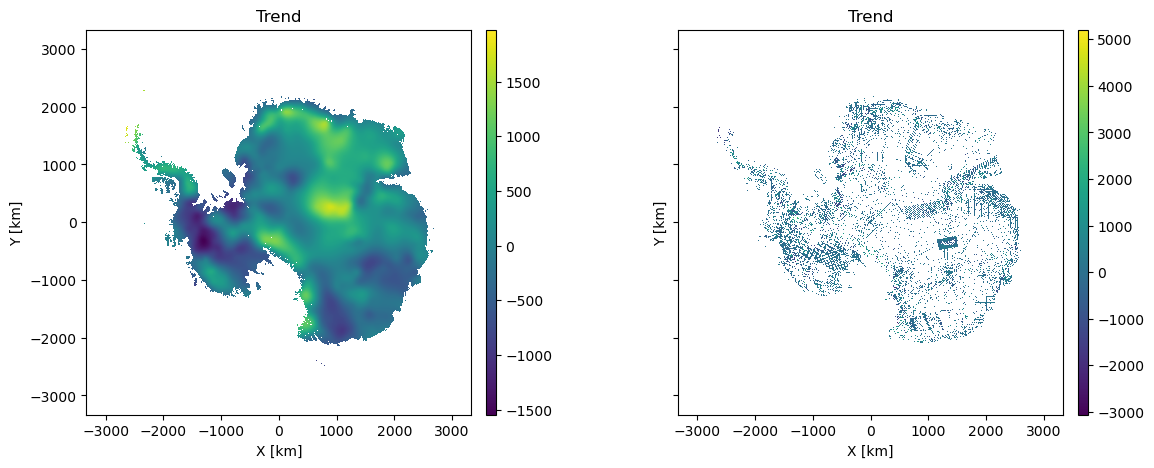

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(14,5), sharey=True)
ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, trend)
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('Trend')

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, res_cond)
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('Trend')

plt.show()

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.hist(res_cond[cond_msk], bins=50)
ax.set_xlabel('residual')
ax.set_title('residual histogram')

plt.show()

In [9]:
sim = np.load('exp_simulation.npy')

In [11]:
ilow = 1000
ihigh = 5800
jlow = 700
jhigh = 6200

xx_trim = xx[ilow:ihigh,jlow:jhigh]
yy_trim = yy[ilow:ihigh,jlow:jhigh]
sim_trim = sim[ilow:ihigh,jlow:jhigh]
trend_trim = trend[ilow:ihigh,jlow:jhigh]

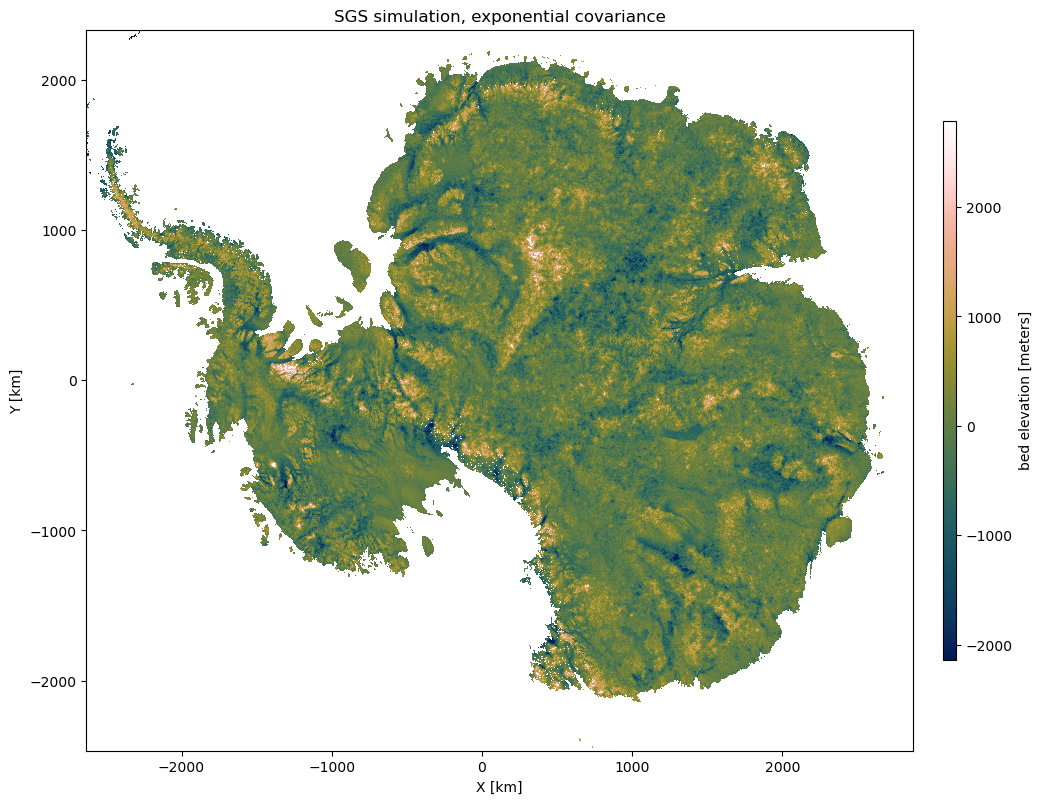

In [12]:
plt.figure(figsize=(13,10))
im = plt.pcolormesh(xx_trim/1000, yy_trim/1000, sim_trim, cmap=cm.batlowW)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('SGS simulation, exponential covariance')
plt.colorbar(im, pad=0.03, aspect=40, shrink=0.7, label='bed elevation [meters]')
plt.savefig('simulation.png', dpi=300, bbox_inches='tight')
plt.show()

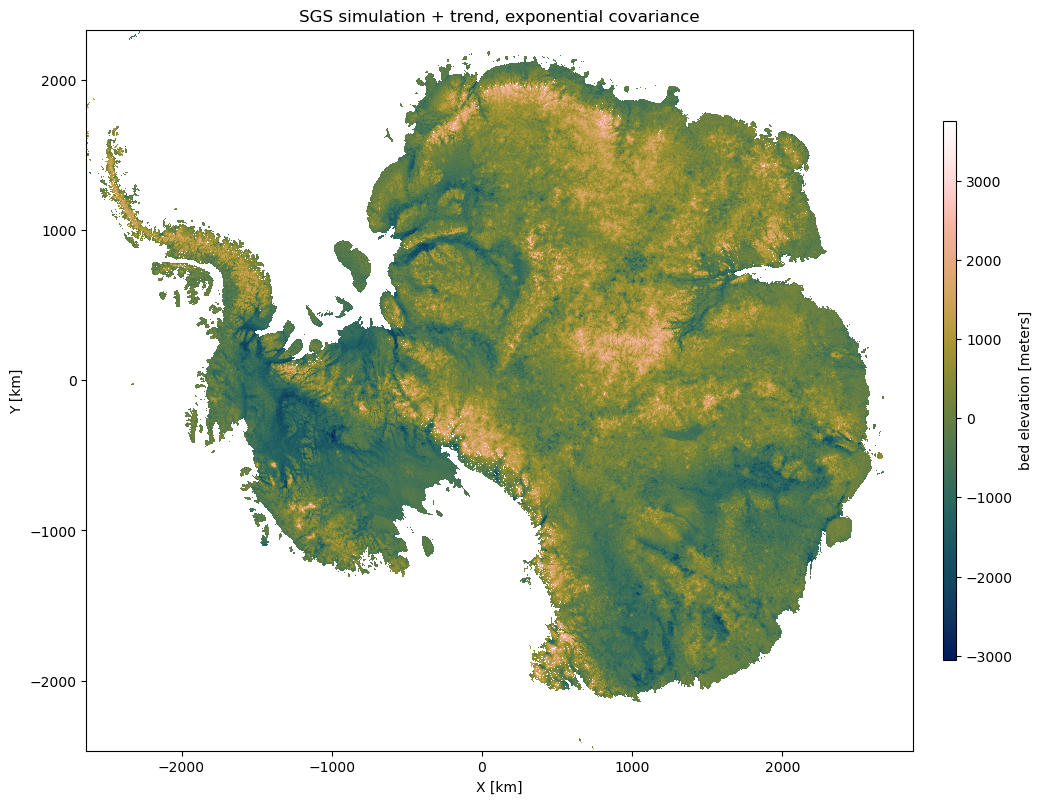

In [13]:
plt.figure(figsize=(13,10))
im = plt.pcolormesh(xx_trim/1000, yy_trim/1000, sim_trim+trend_trim, cmap=cm.batlowW)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('SGS simulation + trend, exponential covariance')
plt.colorbar(im, pad=0.03, aspect=40, shrink=0.7, label='bed elevation [meters]')
plt.savefig('simulation_trend.png', dpi=300, bbox_inches='tight')
plt.show()

In [35]:
ilow = 3000
ihigh = 4800
jlow = 1500
jhigh = 3500

xx_trim = xx[ilow:ihigh,jlow:jhigh]
yy_trim = yy[ilow:ihigh,jlow:jhigh]
sim_trim = np.where(ds.mask==4, ds.bed_topography.values, sim)[ilow:ihigh,jlow:jhigh]
trend_trim = trend[ilow:ihigh,jlow:jhigh]
cond_trim = bed_cond[ilow:ihigh,jlow:jhigh]

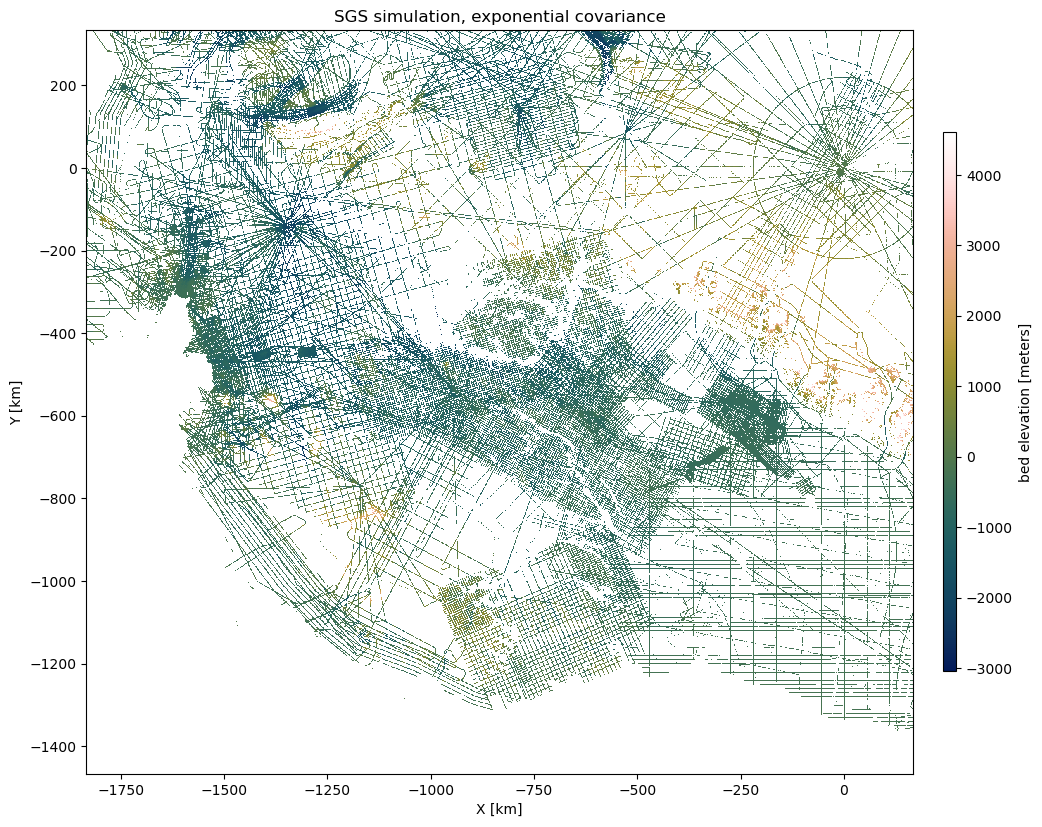

In [23]:
plt.figure(figsize=(13,10))
im = plt.pcolormesh(xx_trim/1000, yy_trim/1000, cond_trim, cmap=cm.batlowW)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('SGS simulation, exponential covariance')
plt.colorbar(im, pad=0.03, aspect=40, shrink=0.7, label='bed elevation [meters]')
plt.show()

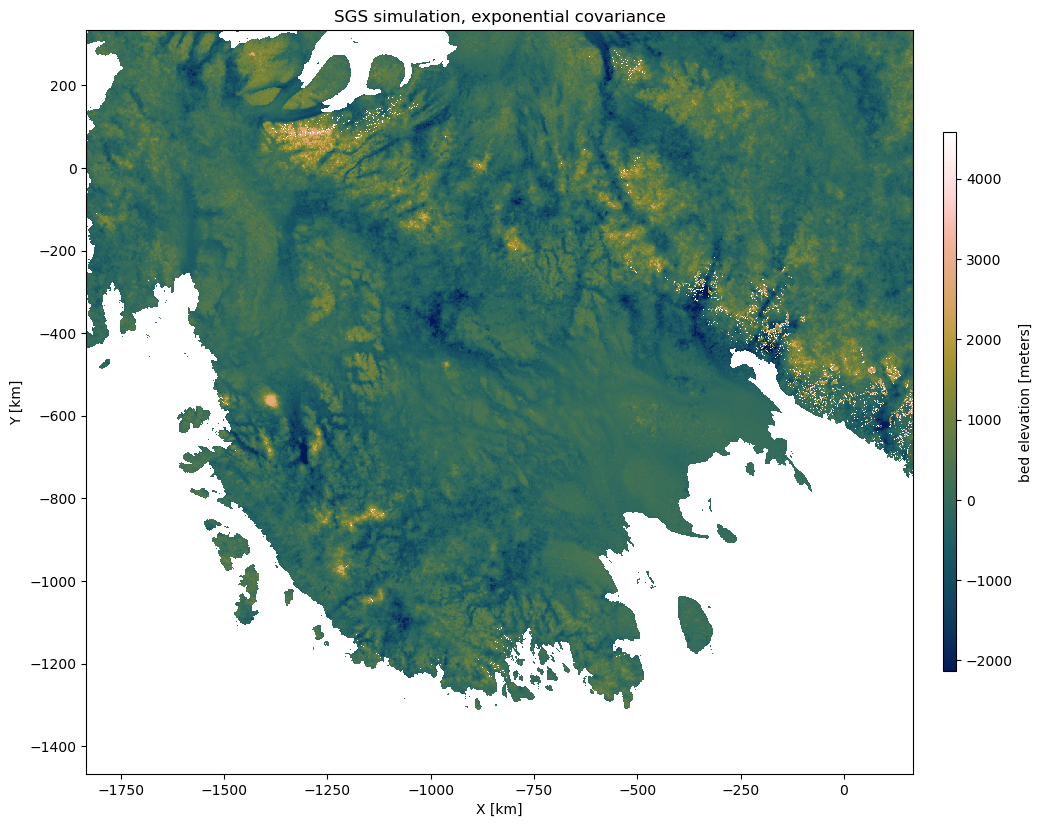

In [39]:
plt.figure(figsize=(13,10))
im = plt.pcolormesh(xx_trim/1000, yy_trim/1000, sim_trim, cmap=cm.batlowW)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('SGS simulation, exponential covariance')
plt.colorbar(im, pad=0.03, aspect=40, shrink=0.7, label='bed elevation [meters]')
plt.show()

In [45]:
plt.figure(figsize=(13,10))
im = plt.pcolormesh(xx_trim/1000, yy_trim/1000, sim_trim+trend_trim, cmap=cm.batlowW)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('SGS simulation + trend, exponential covariance')
plt.colorbar(im, pad=0.03, aspect=40, shrink=0.7, label='bed elevation [meters]')
plt.show()

In [47]:
plt.figure(figsize=(13,10))
im = plt.pcolormesh(xx_trim/1000, yy_trim/1000, ds.bed_topography.values[ilow:ihigh,jlow:jhigh]-(sim_trim+trend_trim), cmap=cm.vik, vmin=-2000, vmax=2000)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('Difference with Bedmap3')
plt.colorbar(im, pad=0.03, aspect=40, shrink=0.7, label='bed elevation [meters]')
plt.show()

In [42]:
np.unique(ds.mask.values[ilow:ihigh,jlow:jhigh], np.nan)

(array([ 1.,  2.,  3.,  4., nan], dtype=float32),
 array([    6,    14,   336, 74079,     0]))